In [1]:
import conllu

In [2]:
with open('datasets/fr_sequoia-ud-train.conllu') as fp:
    data = conllu.parse(fp.read())

In [48]:
data[100].to_tree()

TokenTree<token={id=8, form=entré}, children=[...]>

In [3]:
def load_conllu(filename):
    with open(filename) as fp:
        data = conllu.parse(fp.read())
        sentences = [[token['form'] for token in sentence] for sentence in data]
        taggings = [[token['upos'] for token in sentence] for sentence in data]
    return sentences, taggings

train_sentences, train_taggings = load_conllu('./datasets/fr_sequoia-ud-train.conllu')
valid_sentences, valid_taggings = load_conllu('./datasets/fr_sequoia-ud-dev.conllu')
test_sentences, test_taggings = load_conllu('./datasets/fr_sequoia-ud-test.conllu')

print(train_sentences[10])
print(train_taggings[10])

['"', 'Tout', 'simplement', '"', ',', 'a', 'prÃ©cisÃ©', 'Roger', 'Thiriot', ',', '"', 'parce', 'que', "l'", 'histoire', 'du', 'de', 'le', 'travail', 'industriel', 'est', ',', 'ici', ',', 'une', 'longue', 'et', 'vieille', 'histoire', '.']
['PUNCT', 'ADV', 'ADV', 'PUNCT', 'PUNCT', 'AUX', 'VERB', 'PROPN', 'PROPN', 'PUNCT', 'PUNCT', 'SCONJ', 'SCONJ', 'DET', 'NOUN', '_', 'ADP', 'DET', 'NOUN', 'ADJ', 'AUX', 'PUNCT', 'ADV', 'PUNCT', 'DET', 'ADJ', 'CCONJ', 'ADJ', 'NOUN', 'PUNCT']


In [4]:
len(train_sentences)

2231

In [5]:
# use a defaultdict to count the number of occurrences of each tag
import collections
tagset = collections.defaultdict(int)

for tagging in train_taggings:
    for tag in tagging:
        tagset[tag] += 1

print('number of different tags:', len(tagset))

# print count and tag sorted by decreasing count
for tag, count in sorted(tagset.items(), reverse=True, key=lambda x: x[1]):
    print(count, tag)

number of different tags: 17
10870 NOUN
8043 ADP
7430 DET
5702 PUNCT
4248 VERB
3125 ADJ
2410 PROPN
2083 PRON
1889 ADV
1623 AUX
1360 _
1203 CCONJ
1183 NUM
550 SCONJ
128 X
15 SYM
3 INTJ


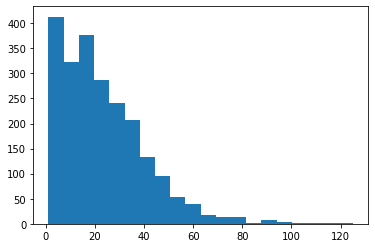

max length: 125


In [6]:
from matplotlib import pyplot as plt

# compute and show histogram for sentence length
plt.hist([len(sentence) for sentence in train_sentences], 20)
plt.show()

# compute max sentence length
print('max length:', max([len(sentence) for sentence in train_sentences]))

In [8]:
from mangoes.modeling import PretrainedTransformerModelForFeatureExtraction
Camembert_model = PretrainedTransformerModelForFeatureExtraction.load("camembert-base", "camembert-base", device=None)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
output = Camembert_model.generate_outputs(" ".join(valid_sentences[1]), pre_tokenized=False, output_hidden_states=True, output_attentions=False, word_embeddings=True)
output['hidden_states'][-1][0].shape


torch.Size([15, 768])

In [10]:
tagsSet = set()
for sent in train_taggings:
    for tag in sent:
        tagsSet.add(tag)
tagsList =  list(tagsSet)
tag_to_indx = {k: v for v, k in enumerate(tagsList)}
indx_to_tag = {v: k for k, v in tag_to_indx.items()}

In [11]:
import pandas as pd

def encode(data_y):
    encoded_y = []
    for sent in data_y:
        tag_list = []
        for tag in sent.split(' '):
            tag_list.append(str(tag_to_indx[tag]))

        encoded_y.append(" ".join(tag_list))
    return encoded_y

train_x = [" ".join(x) for x in train_sentences]
train_y = [" ".join(x) for x in train_taggings]
train_y = encode(train_y)
train_data = pd.DataFrame({"X": train_x, "y": train_y})

valid_x = [" ".join(x) for x in valid_sentences]
valid_y = [" ".join(x) for x in valid_taggings]
valid_y = encode(valid_y)
valid_data = pd.DataFrame({"X": valid_x, "y": valid_y})

test_x = [" ".join(x) for x in test_sentences]
test_y = [" ".join(x) for x in test_taggings]
test_y = encode(test_y)
test_data = pd.DataFrame({"X": test_x, "y": test_y})

In [12]:
from torch.utils.data import Dataset, DataLoader, random_split, Subset

BATCH_SIZE = 8

class PandasDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentence = self.data.loc[index, "X"]
        return {"X": sentence, "y": self.data.loc[index, "y"]}
    
train_dataloader = DataLoader(PandasDataset(train_data), 
                              shuffle=True, batch_size=BATCH_SIZE
)
val_dataloader = DataLoader(PandasDataset(valid_data), 
                            batch_size=BATCH_SIZE)

test_dataloader = DataLoader(PandasDataset(test_data), 
                             batch_size=BATCH_SIZE
)

In [13]:
example_batch = next(iter(train_dataloader))
output = Camembert_model.generate_outputs(example_batch["X"], pre_tokenized=False, output_hidden_states=True, output_attentions=False, word_embeddings=True)
output['hidden_states'][-1].shape

torch.Size([8, 59, 768])

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


In [15]:
class BiLSTMPOSTagger(nn.Module):
    def __init__(self, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers, 
                 bidirectional, 
                 dropout):
        
        super().__init__()
         
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers = n_layers, 
                            bidirectional = bidirectional,
                            dropout = dropout if n_layers > 1 else 0)
        
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, embedded):
        #embedded = [sent len, batch size, emb dim]
        
        #pass embeddings into LSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        
        #outputs holds the backward and forward hidden states in the final layer
        #hidden and cell are the backward and forward hidden and cell states at the final time-step
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden/cell = [n layers * n directions, batch size, hid dim]
        
        #we use our outputs to make a prediction of what the tag should be
        predictions = self.fc(self.dropout(outputs))
        
        #predictions = [sent len, batch size, output dim]
        
        return predictions

In [16]:
EMBEDDING_DIM = 768
HIDDEN_DIM = 128
OUTPUT_DIM = len(tagsList)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.1
TAG_PAD_IDX = tag_to_indx["_"]

model = BiLSTMPOSTagger(EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        N_LAYERS, 
                        BIDIRECTIONAL, 
                        DROPOUT)

In [17]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)
        
model.apply(init_weights)


optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,319,185 trainable parameters


In [19]:
result = model(output['hidden_states'][-1])
result.shape

torch.Size([8, 59, 17])

In [20]:
def categorical_accuracy(preds, y, tag_pad_idx):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / y[non_pad_elements].shape[0]

In [21]:
def pad_Tag(batch_y, max_len):
    # if(max_len == None):
    #     max_len =  max([len(x.split(' ')) for x in batch_y])
    padded_batch = []
    for sent in batch_y:
        sent_list = sent.split(' ')
        sent_list = [int(x) for x in sent_list]
        while(len(sent_list)< max_len):
            sent_list.append(TAG_PAD_IDX)
        padded_batch.append(sent_list)
    return padded_batch
# padded_batch = pad_Tag(example_batch["y"])

In [29]:
def train(model, pretrained_model, iterator, optimizer, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        text = batch["X"]
        output = pretrained_model.generate_outputs(text, pre_tokenized=False, output_hidden_states=True, output_attentions=False, word_embeddings=True)
        embedded = output['hidden_states'][-1]
        tags = batch["y"]
        
        optimizer.zero_grad()
        
        #text = [sent len, batch size] 
        #embedded = [sent len, batch size, emb dim]
        predictions = model(embedded)
        max_len = predictions.shape[1]
        tags = torch.LongTensor(pad_Tag(tags, max_len))
        #predictions = [sent len, batch size, output dim]
        #tags = [sent len, batch size]
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)
            
        #predictions = [sent len * batch size, output dim]
        
        #tags = [sent len * batch size]
        
        loss = criterion(predictions, tags)
                
        acc = categorical_accuracy(predictions, tags, tag_pad_idx)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [30]:
def evaluate(model, pretrained_model, iterator, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text = batch["X"]
            output = pretrained_model.generate_outputs(text, pre_tokenized=False,
                                                        output_hidden_states=True, 
                                                        output_attentions=False, 
                                                        word_embeddings=True)
            embedded = output['hidden_states'][-1]
            tags = batch["y"]
            
            predictions = model(embedded)
            
            max_len = predictions.shape[1]
            tags = torch.LongTensor(pad_Tag(tags, max_len))
            
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)
            
            loss = criterion(predictions, tags)
            
            acc = categorical_accuracy(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [31]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
import time

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, Camembert_model, train_dataloader, optimizer, criterion, TAG_PAD_IDX)
    valid_loss, valid_acc = evaluate(model, Camembert_model,val_dataloader, criterion, TAG_PAD_IDX)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')



Epoch: 01 | Epoch Time: 9m 54s
	Train Loss: 1.860 | Train Acc: 38.35%
	 Val. Loss: 1.599 |  Val. Acc: 46.22%
Epoch: 02 | Epoch Time: 9m 46s
	Train Loss: 1.521 | Train Acc: 48.34%
	 Val. Loss: 1.514 |  Val. Acc: 47.99%
Epoch: 03 | Epoch Time: 9m 48s
	Train Loss: 1.425 | Train Acc: 50.59%
	 Val. Loss: 1.451 |  Val. Acc: 49.49%
Epoch: 04 | Epoch Time: 10m 30s
	Train Loss: 1.369 | Train Acc: 52.30%
	 Val. Loss: 1.422 |  Val. Acc: 49.57%
Epoch: 05 | Epoch Time: 10m 59s
	Train Loss: 1.323 | Train Acc: 53.37%
	 Val. Loss: 1.428 |  Val. Acc: 50.03%
Epoch: 06 | Epoch Time: 11m 37s
	Train Loss: 1.282 | Train Acc: 54.49%
	 Val. Loss: 1.403 |  Val. Acc: 50.38%
Epoch: 07 | Epoch Time: 10m 44s
	Train Loss: 1.254 | Train Acc: 55.01%
	 Val. Loss: 1.385 |  Val. Acc: 51.00%
Epoch: 08 | Epoch Time: 106m 42s
	Train Loss: 1.209 | Train Acc: 56.65%
	 Val. Loss: 1.422 |  Val. Acc: 50.70%
Epoch: 09 | Epoch Time: 7m 13s
	Train Loss: 1.182 | Train Acc: 57.48%
	 Val. Loss: 1.389 |  Val. Acc: 50.66%
Epoch: 10 | E

In [26]:
model.load_state_dict(torch.load('tut1-model.pt'))
test_loss, test_acc = evaluate(model, test_dataloader, criterion, TAG_PAD_IDX)
print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.344 |  Test Acc: 52.20%


In [35]:
Flaubert_model = PretrainedTransformerModelForFeatureExtraction.load('bert-base-multilingual-cased',
                                                                      'bert-base-multilingual-cased', device=None)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, Flaubert_model, train_dataloader, optimizer, criterion, TAG_PAD_IDX)
    valid_loss, valid_acc = evaluate(model, Flaubert_model,val_dataloader, criterion, TAG_PAD_IDX)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 8m 6s
	Train Loss: 0.588 | Train Acc: 82.64%
	 Val. Loss: 0.302 |  Val. Acc: 92.57%
Epoch: 02 | Epoch Time: 7m 37s
	Train Loss: 0.199 | Train Acc: 94.72%
	 Val. Loss: 0.252 |  Val. Acc: 93.81%
Epoch: 03 | Epoch Time: 7m 29s
	Train Loss: 0.143 | Train Acc: 96.43%
	 Val. Loss: 0.224 |  Val. Acc: 94.52%
Epoch: 04 | Epoch Time: 8m 29s
	Train Loss: 0.112 | Train Acc: 97.17%
	 Val. Loss: 0.219 |  Val. Acc: 94.83%
Epoch: 05 | Epoch Time: 8m 50s
	Train Loss: 0.088 | Train Acc: 97.78%
	 Val. Loss: 0.214 |  Val. Acc: 94.90%
Epoch: 06 | Epoch Time: 8m 34s
	Train Loss: 0.071 | Train Acc: 98.17%
	 Val. Loss: 0.224 |  Val. Acc: 94.92%
Epoch: 07 | Epoch Time: 264m 56s
	Train Loss: 0.061 | Train Acc: 98.38%
	 Val. Loss: 0.219 |  Val. Acc: 94.93%
Epoch: 08 | Epoch Time: 14m 26s
	Train Loss: 0.049 | Train Acc: 98.66%
	 Val. Loss: 0.230 |  Val. Acc: 94.94%
Epoch: 09 | Epoch Time: 15m 15s
	Train Loss: 0.040 | Train Acc: 98.90%
	 Val. Loss: 0.232 |  Val. Acc: 95.09%
Epoch: 10 | Epoc

In [33]:
output = Flaubert_model.generate_outputs(example_batch["X"], pre_tokenized=False, 
                                         output_hidden_states=True, output_attentions=False, 
                                         word_embeddings=True)
output['hidden_states'][-1].shape

c:\experiments\package-env\lib\site-packages\mangoes\modeling\bert_base.py:247: RuntimeWarning: Tokenizer type does not support offset mappings, so word embedding consolidation is not possible
  warnings.warn("Tokenizer type does not support offset mappings, so word embedding consolidation is not "


torch.Size([8, 85, 768])

In [34]:
example_batch["X"]

["Les patients doivent Ãªtre correctement hydratÃ©s avant l' administration d' Aclasta .",
 'Une agrÃ©able surprise qui attendait les enfants dÃ¨s le matin .',
 'Affaire des de les piastres',
 "Il n' existe pas d' antidote connu pour la bivalirudine , mais son effet disparaÃ®t rapidement ( TÂ½ 35 Ã\xa0 40 minutes ) .",
 "- Dimanche 1er fÃ©vrier 2004 : Le prÃ©sident Jacques Chirac demande la crÃ©ation d' une commission d' enquÃªte sur les effractions et les pressions dont auraient eu Ã\xa0 subir les magistrats de Nanterre ayant eu Ã\xa0 suivre le dossier de l' Affaire des de les emplois fictifs de la mairie de Paris dans lequel est impliquÃ© Alain JuppÃ© .",
 'Ces dÃ©lÃ©guÃ©s remercient le maire pour avoir pris ses responsabilitÃ©s en amÃ©nageant le parking de la Tour du de le Champ .',
 "Pour plus d' informations sur votre condition ou votre traitement , veuillez consulter la notice ( Ã©galement comprise dans l' EPAR ) ou contacter votre mÃ©decin ou votre pharmacien .",
 "Il n' existe 